In [99]:
import vof
from vof import forecaster
from vof import optimizer

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import altair as alt
import pandas as pd
import statsmodels.api as sm
from darts.utils.statistics import check_seasonality, plot_acf, plot_residuals_analysis
import statsmodels.tsa.stattools
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import time
import random
#from fbprophet import Prophet
from sklearn.model_selection import train_test_split
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
from datetime import date
import nevergrad as ng
from joblib import Parallel, delayed
import time

from darts.utils import timeseries_generation as tg
from darts import TimeSeries
from darts.metrics import rmse
# from darts import SeasonalityMode, TrendMode, ModelMode

from darts.models import Theta, FFT, ExponentialSmoothing, Prophet, RegressionModel,NaiveSeasonal,LightGBMModel,RandomForest,forecasting
# import darts.models
from darts.utils.utils import SeasonalityMode, TrendMode, ModelMode


plt.rcParams['figure.figsize'] = [18, 8]
plt.rcParams.update({'font.size': 22})

In [101]:
'''data = pd.read_csv('data/ecomm/sales_train_data_merged.csv',index_col=0).fillna(0)
data

top_items = data.groupby('item_id').sum().sort_values(by='sales').index[-100:]
data.loc[data.item_id.isin(top_items)].to_csv('data/ecomm/sales_train_data_merged_top100_items.csv')'''

"data = pd.read_csv('data/ecomm/sales_train_data_merged.csv',index_col=0).fillna(0)\ndata\n\ntop_items = data.groupby('item_id').sum().sort_values(by='sales').index[-100:]\ndata.loc[data.item_id.isin(top_items)].to_csv('data/ecomm/sales_train_data_merged_top100_items.csv')"

In [102]:
data = pd.read_csv('data/ecomm/sales_train_data_merged_top100_items.csv',index_col=0).fillna(0)
data.index = data.index.astype('datetime64[ns]')

#data['sin_wday'] = np.sin(2*np.pi*data.wday/7)
#data['cos_wday'] = np.cos(2*np.pi*data.wday/7)

#data.set_index('date', inplace=True)
data_subset = data.loc['2011-10-01':'2012-10-01']

In [103]:
data_subset

item_id  sell_price  wday  snap_CA  snap_TX  snap_WI  \
date                                                                       
2012-03-03      FOODS_1_004       1.780   1.0      1.0      1.0      1.0   
2012-03-04      FOODS_1_004       1.780   2.0      1.0      0.0      0.0   
2012-03-05      FOODS_1_004       1.780   3.0      1.0      1.0      1.0   
2012-03-06      FOODS_1_004       1.780   4.0      1.0      1.0      1.0   
2012-03-07      FOODS_1_004       1.780   5.0      1.0      1.0      0.0   
...                     ...         ...   ...      ...      ...      ...   
2012-09-27  HOUSEHOLD_1_521       0.961   6.0      0.0      0.0      0.0   
2012-09-28  HOUSEHOLD_1_521       0.961   7.0      0.0      0.0      0.0   
2012-09-29  HOUSEHOLD_1_521       0.961   1.0      0.0      0.0      0.0   
2012-09-30  HOUSEHOLD_1_521       0.961   2.0      0.0      0.0      0.0   
2012-10-01  HOUSEHOLD_1_521       0.961   3.0      1.0      1.0      0.0   

            sales  special_events      sin_wday  cos_wday  
date                                                       
2012-03-03    0.0             0.0  7.818315e-01  0.623490  
2012-03-04    0.0             0.0  9.749279e-01 -0.222521  
2012-03-05    0.0             0.0  4.338837e-01 -0.900969  
2012-03-06    0.0             0.0 -4.338837e-01 -0.900969  
2012-03-07    1.0             0.0 -9.749279e-01 -0.222521  
...           ...             ...           ...       ...  
2012-09-27   40.0             0.0 -7.818315e-01  0.623490  
2012-09-28   51.0             0.0 -2.449294e-16  1.000000  
2012-09-29   84.0             0.0  7.818315e-01  0.623490  
2012-09-30   60.0             0.0  9.749279e-01 -0.222521  
2012-10-01   76.0             0.0  4.338837e-01 -0.900969  

[30760 rows x 10 columns]

In [104]:
top_items = data_subset.groupby('item_id').sum().sort_values(by='sales').index[-3:]

alt.data_transformers.disable_max_rows()

alt.Chart(data_subset.loc[data_subset.item_id.isin(top_items)].reset_index()).mark_line().encode(
    x='date:T',
    y=alt.Y('sales:Q'),
    color='item_id',
    tooltip=['item_id','date:T','sales:Q']
).properties(width=500, height=400)

alt.Chart(...)

In [105]:
def get_input_item(item_id='FOODS_3_555'):
    item = data_subset.loc[data_subset.item_id.isin([item_id])]
    item.loc[item.sales<10,'sales'] = item.sales.median()
    return item

In [106]:
def eval_model(model, 
               input_timeseries,
               past_covariates=None, 
               future_covariates=None, 
               retrain = False, 
               plot_backtest=True):
    # Past and future covariates are optional because they won't always be used in our tests
    
    # We backtest the model on the last 20% of the flow series, with a horizon of 10 steps:
    backtest = model.historical_forecasts(series=input_timeseries, 
                                          past_covariates=past_covariates,
                                          future_covariates=future_covariates,
                                          start=0.33, 
                                          retrain=retrain,
                                          verbose=True, 
                                          forecast_horizon=7)
    
    if plot_backtest:
        input_timeseries[-len(backtest)-14:].plot()
        backtest.plot(label='backtest (n=10)')
    print(str(model)+' Backtest RMSE = {}'.format(rmse(input_timeseries, backtest)))


def get_historical_forecasts(model, 
                             input_timeseries,
                             future_covariates,
                             model_display_name, 
                             future_covs=False):

    horizon = 7
    
    if future_covs == False:
        #print(model_display_name, 'no future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              start=60, 
                                              last_points_only=False, 
                                              overlap_end=False)
    else:
        #print(model_display_name, 'with future_covs')
        forecast = model.historical_forecasts(input_timeseries,
                                              forecast_horizon=horizon, 
                                              stride=1, 
                                              verbose=True,
                                              future_covariates=future_covariates,
                                              start=60,
                                              last_points_only=False,
                                              overlap_end=False)
        
    res_df = pd.DataFrame()

    for i in range(len(forecast)):
        pred_df = forecast[i].pd_dataframe()
        pred_df['prediction_date'] = forecast[i].get_timestamp_at_point(0)
        pred_df['model'] = model_display_name
        pred_df.reset_index(inplace=True)
        pred_df.columns = ['ts','value','prediction_date','model']
        res_df = res_df.append(pred_df)
    
    if future_covs == False:
        return res_df.iloc[:-(horizon*7)]
    else:
        return res_df
    #return res_df

In [107]:
def create_forecast_for_item(itemid):
    
    input_timeseries = TimeSeries.from_dataframe(get_input_item(itemid), value_cols=['sales'])

    future = TimeSeries.from_dataframe(get_input_item(itemid), 
                                       value_cols=['sin_wday','cos_wday','special_events'])
    
    print(future)
    # We first set aside the first 33% as training series:
    input_train, _ = input_timeseries.split_before(0.33)

    #naive_model_daily = NaiveSeasonal(K=1)
    #naive_model_daily.fit(input_train)

    naive_model_weekly = NaiveSeasonal(K=7)
    naive_model_weekly.fit(input_train)

    regr_model_lags =  RegressionModel(lags=list(range(-14,0)))
    regr_model_lags.fit(input_train)

    regr_model_cov = RegressionModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    regr_model_cov.fit(input_train,future_covariates=future)

    lgbm_model_cov = LightGBMModel(lags=list(range(-14,0)),lags_future_covariates=[-14,-7,0,1,7])
    lgbm_model_cov.fit(input_train,future_covariates=future)

    lgbm_model = LightGBMModel(lags=list(range(-14,0)))
    lgbm_model.fit(input_train)
    
    theta_model =  Theta(2, seasonality_period=7, season_mode=SeasonalityMode.MULTIPLICATIVE)
    theta_model.fit(input_train)



    #eval_model(naive_model_daily, input_timeseries, retrain=True, plot_backtest=False)
    #eval_model(naive_model_weekly,input_timeseries, retrain=True, plot_backtest=False)
    #eval_model(regr_model_lags,input_timeseries, plot_backtest=False)
    #eval_model(regr_model_cov,input_timeseries, plot_backtest=False)
    #eval_model(lgbm_model_cov,input_timeseries, plot_backtest=False)
    
    models = {'Naive weekly':[naive_model_weekly,False],
              'RegressionModelLags':[regr_model_lags,False],
              'RegressionModelCov':[regr_model_cov,True],
              'LGBM_cov':[lgbm_model_cov,True],
              'LGBM_no_cov':[lgbm_model,False],
              'Theta':[theta_model,False],
              #'FFT':[fft_model,False],
              #'ExponentialSmoothing':[exp_smooth_model,False],
              #'Prophet':[prophet_model,False]
         }

    forcasts_df = pd.DataFrame()

    runtime_df = pd.DataFrame(index=models.keys(),columns=['runtime'])
    
    parallel_forecasts = (Parallel(n_jobs=-1, verbose = 1000)\
                          (delayed(get_historical_forecasts)(models[model][0],
                                                             input_timeseries=input_timeseries,
                                                             model_display_name = model,
                                                             future_covariates=future,
                                                             future_covs = models[model][1]) for model in models.keys()))
    #merge all models into a single dataframe forcasts_df
    for i in parallel_forecasts:
        forcasts_df = forcasts_df.append(i)

    forcasts_df['item_id'] = itemid

    return forcasts_df


In [108]:
optimization_df_parallel = (Parallel(n_jobs=-1, verbose = 1000)\
                            (delayed(create_forecast_for_item)(item) for item in top_items.values))

#merge all items into a single dataframe
optimization_df = pd.DataFrame()
for i in optimization_df_parallel:
    optimization_df = optimization_df.append(i)

    optimization_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:  2.5min finished


In [109]:
fact = optimization_df.loc[optimization_df.model=='Naive weekly'].copy()#.join('tmp.y.loc[optimization_df.index]')
fact.set_index(['ts','item_id'], inplace=True)
fact['model'] = 'Fact'
fact['value'] = data.reset_index().set_index(['date','item_id'])['sales']

fact.reset_index(inplace=True)

if len(optimization_df.loc[optimization_df.model=='Fact'])==0:
    optimization_df = optimization_df.append(fact)

In [110]:
alt.data_transformers.disable_max_rows()

alt.Chart(optimization_df.reset_index()).mark_line().encode(
    x='ts:T',
    y=alt.Y('value:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('prediction_date:N', legend=None),
    row='model:N',
    column='item_id:N'
).properties(width=200, height=150)#.interactive()

alt.Chart(...)

### Evaluation function for all item_ids

In [111]:
#optimization_df.set_index(['item_id','prediction_date','ts'])
from sklearn import metrics
import math 
def get_item_rmse(item_id):
    
    res = pd.DataFrame(index=optimization_df.model.unique(), columns=['rmse'])
    
    df = optimization_df.loc[optimization_df.item_id==item_id].set_index(['prediction_date','ts'])
        
    for m in optimization_df.model.unique():
        mse = metrics.mean_squared_error(df.loc[df.model=='Fact','value'],df.loc[df.model==m,'value'])        
        res.loc[m,'rmse'] = math.sqrt(mse)
    
    res['rmse_normalized'] = res['rmse']/res.loc['Naive weekly','rmse']
    res['item_id'] = item_id
    #res = res.drop('Fact').reset_index()
    res.reset_index(inplace=True)
    res.columns = ['model','rmse','rmse_normalized','item_id']
    return res

eval_df = pd.DataFrame()

for item in top_items.values:
    eval_df = eval_df.append(get_item_rmse(item), ignore_index=True)
    
eval_df

model        rmse rmse_normalized      item_id
0          Naive weekly   64.569724             1.0  FOODS_3_555
1   RegressionModelLags   62.053983        0.961038  FOODS_3_555
2    RegressionModelCov   63.057524         0.97658  FOODS_3_555
3              LGBM_cov   58.054215        0.899093  FOODS_3_555
4           LGBM_no_cov   63.409782        0.982036  FOODS_3_555
5                 Theta   57.579791        0.891746  FOODS_3_555
6                  Fact         0.0             0.0  FOODS_3_555
7          Naive weekly  106.292693             1.0  FOODS_3_586
8   RegressionModelLags  103.629885        0.974948  FOODS_3_586
9    RegressionModelCov   113.37055        1.066588  FOODS_3_586
10             LGBM_cov  105.171102        0.989448  FOODS_3_586
11          LGBM_no_cov  106.331146        1.000362  FOODS_3_586
12                Theta    96.27076        0.905714  FOODS_3_586
13                 Fact         0.0             0.0  FOODS_3_586
14         Naive weekly  197.483355             1.0  FOODS_3_090
15  RegressionModelLags  224.584335        1.137232  FOODS_3_090
16   RegressionModelCov   317.83504        1.609427  FOODS_3_090
17             LGBM_cov  193.385215        0.979248  FOODS_3_090
18          LGBM_no_cov  201.460331        1.020138  FOODS_3_090
19                Theta  170.759775        0.864679  FOODS_3_090
20                 Fact         0.0             0.0  FOODS_3_090

In [112]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=100, height=150)#.interactive()

alt.Chart(...)

In [113]:
(eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/5).reset_index()

model  rmse_normalized       rmse
0                 Fact         0.000000   0.000000
1             LGBM_cov         0.573558  71.322106
2          LGBM_no_cov         0.600507  74.240252
3         Naive weekly         0.600000  73.669154
4   RegressionModelCov         0.730519  98.852623
5  RegressionModelLags         0.614644  78.053641
6                Theta         0.532428  64.922065

In [114]:
alt.Chart((eval_df.groupby(['model']).sum()[['rmse_normalized','rmse']]/5).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    color=alt.Color('model:N'),
).properties(width=200, height=250)#.interactive()

alt.Chart(...)

# Optimizer

Starting with calculating actual daily revenue for each of the items (value * price) and checking total revenue for the set.
Price for each item is fixed as average of all prices available in data

In [115]:
items_prices = data_subset.loc[data_subset.item_id.isin(top_items)].reset_index().groupby('item_id').mean()['sell_price']
optimization_df.set_index(['item_id'], inplace=True)
optimization_df['sell_price'] = items_prices
optimization_df.reset_index(inplace=True)
optimization_df['daily_revenue'] = optimization_df.value*optimization_df.sell_price

In [116]:
weekly_revenue_bl = optimization_df.groupby(['model','prediction_date']).sum().daily_revenue.reset_index()
weekly_revenue_bl = weekly_revenue_bl.pivot_table(columns='model',index='prediction_date', values='daily_revenue', aggfunc='sum')

In [117]:
alt.Chart(weekly_revenue_bl).transform_fold(
    weekly_revenue_bl.columns.values,
    #['Fact'],
    as_=['Model', 'Measurement']
).mark_bar(
    opacity=0.5,
    binSpacing=0
).encode(
    alt.X('Measurement:Q', bin=alt.Bin(maxbins=50)),
    alt.Y('count()', stack=None),
    alt.Color('Model:N')
    )

alt.Chart(...)

### Optimization target:
* Every week we make predictions for each item and calculate total profit for the week
* Profit is calculated as all the money that we earn minus cost of items for us. Cost of each item is 40% of it's final price. For each sold item we add additional $0.05 as a restock price. We'll restock all the items that we have sold in a week.
* We implement a discounts for each induvidual product to increase sales 
* Effect of a discount is pre-set: we get 3% increase in sales for each 1% discount
* Some limitations: 
 * Amount of discount shouldn't be more than 60% (otherwise we are selling the item with loss)
 * Limit on max amount of items sold is 150% of maximum sold during the period we are looking at

In [118]:
from vof import optimizer

class OptimalDecisionMakersSales(optimizer.OptimalDecisionMakers):
    

    def __init__(self, data, target):
        super().__init__(data, target)
        self.EVALUATE = False
        self.TIME_HORIZON = 7
        self.DECISION_TIMESTEP = 7
        self.MAX_CAPACITY = (data.loc[data.model=='Fact'].groupby(['item_id','prediction_date']).sum().reset_index().groupby('item_id').max()['value']*1.5).apply(math.ceil)
        #self.LOWER_SALES_LIMIT = 19000
        self.BASIC_PRICES = items_prices
        self.LAST2W_DISCOUNTS = [0,0,0,0,0,0]
            
    def cost_function(self,solution,capacity_limits,last_2w_discounts):
        capacity_penalty = 1
        w3_discount_penalty = 1
        penalty_lower_than_forecast = 1

        solution = np.array(solution)/100   
        
        #If the item was on sale for the last 2 weeks, it can't be discounted anymore:                
        #for sol in range(len(solution)):
        #    if last_2w_discounts[sol]>0:
        #        solution[sol]=0  
                    
        self.candidate.set_index('item_id', inplace=True)
        self.candidate['disount'] = self.BASIC_PRICES*(solution)/self.BASIC_PRICES
        self.candidate['sell_price_w_disount'] = self.BASIC_PRICES*(1 - solution)
        self.candidate['value_increase'] = pd.DataFrame(index=self.BASIC_PRICES.index, data=solution*3, columns=['value_increase']) #2% increase in sales for each 1% increase in discount
        

        self.candidate['value_w_disount'] = self.candidate.value + self.candidate.value_increase*self.candidate.value
        self.candidate['daily_revenue_w_disount'] = self.candidate['value_w_disount']*self.candidate['sell_price_w_disount']
        
        self.candidate['daily_profit'] = self.candidate['value']*(self.candidate['sell_price'] - self.candidate['sell_price']*.4)
        self.candidate['daily_profit_w_disount'] = self.candidate['value_w_disount']*(self.candidate['sell_price_w_disount'] - self.candidate['sell_price']*.4)
        
        self.candidate.reset_index(inplace=True)
        
        #penalty for exceeding limit on max amount of items sold (150% of maximum sold during the period we are looking at)
        if any(self.candidate.groupby('item_id').sum()['value_w_disount']>self.MAX_CAPACITY):
            capacity_penalty = 5000
            

        #penalty if daily_profit_w_discount is lower than forecasted profit without it
        if sum(self.candidate['daily_profit_w_disount'])<sum(self.candidate['daily_profit']):
            penalty_lower_than_forecast = 10000
            #print('penalty_lower_than_forecast')        

        total_cost = -sum(self.candidate['daily_profit_w_disount'])+capacity_penalty+penalty_lower_than_forecast #+w3_discount_penalty

        #if (capacity_penalty + w3_discount_penalty + penalty_lower_than_forecast) == 3:
            #print('found a non-penalty solution!', solution,total_cost)


        return total_cost

    
    def calculate_optimal_decision(self, model):
        
        print(model)

        total_steps = self.data.loc[self.data.prediction_date.dt.weekday==1,'prediction_date'].unique()

        #recommendation = np.array([])
        recommendation = pd.DataFrame()
        last_2w_discounts = self.LAST2W_DISCOUNTS
        #counter_2w = 1
        
        for step in total_steps:
            
            print(step)
            
            discounts = ng.p.Choice(range(0,70,10),repetitions=len(top_items))
            
            #print(list(discounts.value))
            
                
            instru = ng.p.Instrumentation(discounts,self.MAX_CAPACITY,last_2w_discounts)
            optimizer = ng.optimizers.CMA(parametrization=instru, budget=1000)
            #optimizer.parametrization.register_cheap_constraint(lambda discounts: discounts[0] >= 1)
            
            try:
                
                self.candidate = self.data.loc[(self.data.prediction_date==step)&(self.data.model==model)]
                
            except:
                
                print(self.data.loc[(self.data.prediction_date==step)&(self.data.model==model),'value'])

            #print('step_recommendation')
            
            step_recommendation = optimizer.minimize(self.cost_function)[0][0].value # self.candidate will be modified inside cost function
                        
            #create a slice for each model and each item with N days in time horizon
            rec_df = self.candidate.set_index(['model','item_id','prediction_date','ts']).loc[(slice(None), 
                                                                                               slice(None),
                                                                                               slice(None), 
                                                                                               pd.date_range(start=step, periods=self.DECISION_TIMESTEP))].reset_index()
            recommendation = recommendation.append(pd.DataFrame(rec_df), ignore_index=True)
            
            #collecting discounts only for 2 last weeks, restart the cycle every 3rd week:
            #if counter_2w%3 == 1:
            #    last_2w_discounts += step_recommendation
            #else:
            #    last_2w_discounts = step_recommendation
            
            #counter_2w +=1
         
        return recommendation
    

    def select_value_optimal_model(self,models,return_predictions=False):
        
        random.seed(42)
                
        self.optimal_decision_result = (Parallel(n_jobs=-1, verbose = 1000)(delayed(self.calculate_optimal_decision)(model) for model in models))

        return self.optimal_decision_result
    
    def evaluate(self):
        return evaluation_df

In [119]:
odm = OptimalDecisionMakersSales(optimization_df,'Fact')

In [120]:
#sol = odm.calculate_optimal_decision(model='Naive weekly')
sol = odm.select_value_optimal_model(models=optimization_df.model.unique())

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done   2 out of   7 | elapsed:  5.7min remaining: 14.4min
[Parallel(n_jobs=-1)]: Done   3 out of   7 | elapsed:  5.8min remaining:  7.7min
[Parallel(n_jobs=-1)]: Done   4 out of   7 | elapsed:  5.8min remaining:  4.3min
[Parallel(n_jobs=-1)]: Done   5 out of   7 | elapsed:  5.8min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.8min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   7 out of   7 | elapsed:  5.8min finished


In [121]:
result_df = pd.DataFrame()

for col in range(len(sol)):
    result_df = result_df.append(sol[col], ignore_index=True)

## Evaluation of optimization based on Fact values

In [122]:
result_df.head()

model      item_id prediction_date         ts  value  sell_price  \
0  Naive weekly  FOODS_3_555      2011-12-06 2011-12-06  193.0    1.541662   
1  Naive weekly  FOODS_3_586      2011-12-06 2011-12-06  386.0    1.541853   
2  Naive weekly  FOODS_3_090      2011-12-06 2011-12-06  618.0    1.344864   
3  Naive weekly  FOODS_3_555      2011-12-06 2011-12-07  218.0    1.541662   
4  Naive weekly  FOODS_3_586      2011-12-06 2011-12-07  412.0    1.541853   

   daily_revenue  disount  sell_price_w_disount  value_increase  \
0     297.540790      0.0              1.541662             0.0   
1     595.155204      0.2              1.233482             0.6   
2     831.125804      0.6              0.537946             1.8   
3     336.082343      0.0              1.541662             0.0   
4     635.243379      0.2              1.233482             0.6   

   value_w_disount  daily_revenue_w_disount  daily_profit  \
0            193.0               297.540790    178.524474   
1            617.6               761.798662    357.093123   
2           1730.4               930.860900    498.675482   
3            218.0               336.082343    201.649406   
4            659.2               813.111525    381.146027   

   daily_profit_w_disount  
0              178.524474  
1              380.899331  
2                0.000000  
3              201.649406  
4              406.555762

In [123]:
result_df.set_index(['item_id','prediction_date','ts'], inplace=True)
result_df = result_df.join(result_df.loc[result_df.model=='Fact',['value','daily_profit']], rsuffix='_fact')
result_df.reset_index(inplace=True)
result_df['value_w_disount_fact'] = result_df['value_fact'] + result_df['value_fact']*result_df['value_increase']
result_df['daily_profit_w_disount_fact'] = result_df['value_w_disount_fact']*(result_df.sell_price_w_disount - result_df.sell_price*.4)

## Inventory:
 * After predicting the demand N with discount we'll buy N items. If in reality the demand is higher - that's the only amount we'll be able to sell
 * If we sell less items that been predicted, the rest goes bad, and the price (40%) is being deducted from the final profit

In [124]:
result_weekly = result_df.groupby(['item_id','model','prediction_date']).sum()
result_weekly[['sell_price','disount','sell_price_w_disount','value_increase']] = result_df.groupby(['item_id','model','prediction_date']).max()[['sell_price','disount','sell_price_w_disount','value_increase']]
result_weekly['inventory_left'] = result_weekly['value_w_disount'] - result_weekly['value_w_disount_fact'] 


result_weekly['final_profit_w_discount'] = result_weekly['daily_profit_w_disount_fact']
result_weekly['final_profit_base_price'] = result_weekly['daily_profit_fact']
# if inventory_left>0 substract 40% of it's price from profits
result_weekly.loc[result_weekly.inventory_left>0,'final_profit_w_discount']  = result_weekly.loc[result_weekly.inventory_left>0,'daily_profit_w_disount_fact'] - result_weekly.loc[result_weekly.inventory_left>0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left>0,'sell_price']*.4
result_weekly.loc[result_weekly.inventory_left>0,'final_profit_base_price']  = result_weekly.loc[result_weekly.inventory_left>0,'daily_profit_fact'] - result_weekly.loc[result_weekly.inventory_left>0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left>0,'sell_price']*.4

# if inventory_lef<0 substract all additional items that we weren't able to sell
result_weekly.loc[result_weekly.inventory_left<0,'final_profit_w_discount'] = result_weekly.loc[result_weekly.inventory_left<0,'daily_profit_w_disount_fact'] - result_weekly.loc[result_weekly.inventory_left<0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left<0,'sell_price_w_disount']
result_weekly.loc[result_weekly.inventory_left<0,'final_profit_base_price'] = result_weekly.loc[result_weekly.inventory_left<0,'daily_profit_fact'] - result_weekly.loc[result_weekly.inventory_left<0,'inventory_left']*result_weekly.loc[result_weekly.inventory_left<0,'sell_price']

result_weekly.head()

value  sell_price  daily_revenue  disount  \
item_id     model prediction_date                                               
FOODS_3_090 Fact  2011-12-06       6244.0    1.344864    8397.329319      0.1   
                  2011-12-13       7228.0    1.344864    9720.675259      0.0   
                  2011-12-20       7341.0    1.344864    9872.644864      0.2   
                  2011-12-27       8046.0    1.344864   10820.773815      0.1   
                  2012-01-03       5964.0    1.344864    8020.767466      0.1   

                                   sell_price_w_disount  value_increase  \
item_id     model prediction_date                                         
FOODS_3_090 Fact  2011-12-06                   1.210377             0.3   
                  2011-12-13                   1.344864             0.0   
                  2011-12-20                   1.075891             0.6   
                  2011-12-27                   1.210377             0.3   
                  2012-01-03                   1.210377             0.3   

                                   value_w_disount  daily_revenue_w_disount  \
item_id     model prediction_date                                             
FOODS_3_090 Fact  2011-12-06                8117.2              9824.875303   
                  2011-12-13                7228.0              9720.675259   
                  2011-12-20               11745.6             12636.985426   
                  2011-12-27               10459.8             12660.305363   
                  2012-01-03                7753.2              9384.297935   

                                   daily_profit  daily_profit_w_disount  \
item_id     model prediction_date                                         
FOODS_3_090 Fact  2011-12-06        5038.397591             5458.264057   
                  2011-12-13        5832.405155             5832.405155   
                  2011-12-20        5923.586918             6318.492713   
                  2011-12-27        6492.464289             7033.502980   
                  2012-01-03        4812.460480             5213.498853   

                                   value_fact  daily_profit_fact  \
item_id     model prediction_date                                  
FOODS_3_090 Fact  2011-12-06           6244.0        5038.397591   
                  2011-12-13           7228.0        5832.405155   
                  2011-12-20           7341.0        5923.586918   
                  2011-12-27           8046.0        6492.464289   
                  2012-01-03           5964.0        4812.460480   

                                   value_w_disount_fact  \
item_id     model prediction_date                         
FOODS_3_090 Fact  2011-12-06                     8117.2   
                  2011-12-13                     7228.0   
                  2011-12-20                    11745.6   
                  2011-12-27                    10459.8   
                  2012-01-03                     7753.2   

                                   daily_profit_w_disount_fact  \
item_id     model prediction_date                                
FOODS_3_090 Fact  2011-12-06                       5458.264057   
                  2011-12-13                       5832.405155   
                  2011-12-20                       6318.492713   
                  2011-12-27                       7033.502980   
                  2012-01-03                       5213.498853   

                                   inventory_left  final_profit_w_discount  \
item_id     model prediction_date                                            
FOODS_3_090 Fact  2011-12-06                  0.0              5458.264057   
                  2011-12-13                  0.0              5832.405155   
                  2011-12-20                  0.0              6318.492713   
                  2011-12-27                  0.0              7033.502980   
                  2012-01-03            

In [138]:
alt.data_transformers.disable_max_rows()

alt.Chart(result_weekly.reset_index()).mark_line().encode(
    x='prediction_date:T',
    y=alt.Y('final_profit_w_discount:Q',scale=alt.Scale(zero=True)),
    color=alt.Color('model:N'),
    #row='model:N',
    column='item_id:N'
).properties(width=300, height=400)#.interactive()

alt.Chart(...)

In [126]:
eval_df

model        rmse rmse_normalized      item_id
0          Naive weekly   64.569724             1.0  FOODS_3_555
1   RegressionModelLags   62.053983        0.961038  FOODS_3_555
2    RegressionModelCov   63.057524         0.97658  FOODS_3_555
3              LGBM_cov   58.054215        0.899093  FOODS_3_555
4           LGBM_no_cov   63.409782        0.982036  FOODS_3_555
5                 Theta   57.579791        0.891746  FOODS_3_555
6                  Fact         0.0             0.0  FOODS_3_555
7          Naive weekly  106.292693             1.0  FOODS_3_586
8   RegressionModelLags  103.629885        0.974948  FOODS_3_586
9    RegressionModelCov   113.37055        1.066588  FOODS_3_586
10             LGBM_cov  105.171102        0.989448  FOODS_3_586
11          LGBM_no_cov  106.331146        1.000362  FOODS_3_586
12                Theta    96.27076        0.905714  FOODS_3_586
13                 Fact         0.0             0.0  FOODS_3_586
14         Naive weekly  197.483355             1.0  FOODS_3_090
15  RegressionModelLags  224.584335        1.137232  FOODS_3_090
16   RegressionModelCov   317.83504        1.609427  FOODS_3_090
17             LGBM_cov  193.385215        0.979248  FOODS_3_090
18          LGBM_no_cov  201.460331        1.020138  FOODS_3_090
19                Theta  170.759775        0.864679  FOODS_3_090
20                 Fact         0.0             0.0  FOODS_3_090

In [127]:
eval_df.set_index(['model','item_id'], inplace=True)
eval_df['profit_increase_%'] = (result_weekly.groupby(['model','item_id']).sum()['final_profit_w_discount'] - result_weekly.groupby(['model','item_id']).sum()['final_profit_base_price'])/result_weekly.groupby(['model','item_id']).sum()['final_profit_base_price']
eval_df.reset_index(inplace=True)

In [128]:
eval_df

model      item_id        rmse rmse_normalized  \
0          Naive weekly  FOODS_3_555   64.569724             1.0   
1   RegressionModelLags  FOODS_3_555   62.053983        0.961038   
2    RegressionModelCov  FOODS_3_555   63.057524         0.97658   
3              LGBM_cov  FOODS_3_555   58.054215        0.899093   
4           LGBM_no_cov  FOODS_3_555   63.409782        0.982036   
5                 Theta  FOODS_3_555   57.579791        0.891746   
6                  Fact  FOODS_3_555         0.0             0.0   
7          Naive weekly  FOODS_3_586  106.292693             1.0   
8   RegressionModelLags  FOODS_3_586  103.629885        0.974948   
9    RegressionModelCov  FOODS_3_586   113.37055        1.066588   
10             LGBM_cov  FOODS_3_586  105.171102        0.989448   
11          LGBM_no_cov  FOODS_3_586  106.331146        1.000362   
12                Theta  FOODS_3_586    96.27076        0.905714   
13                 Fact  FOODS_3_586         0.0             0.0   
14         Naive weekly  FOODS_3_090  197.483355             1.0   
15  RegressionModelLags  FOODS_3_090  224.584335        1.137232   
16   RegressionModelCov  FOODS_3_090   317.83504        1.609427   
17             LGBM_cov  FOODS_3_090  193.385215        0.979248   
18          LGBM_no_cov  FOODS_3_090  201.460331        1.020138   
19                Theta  FOODS_3_090  170.759775        0.864679   
20                 Fact  FOODS_3_090         0.0             0.0   

    profit_increase_%  
0            0.035330  
1            0.023848  
2            0.064767  
3            0.054395  
4            0.047312  
5            0.058806  
6            0.067928  
7            0.019602  
8            0.052634  
9            0.035617  
10           0.021686  
11           0.069644  
12          -0.005064  
13           0.073859  
14           0.003613  
15           0.066662  
16           0.052210  
17           0.055852  
18           0.051915  
19           0.033531  
20           0.074947

In [129]:
alt.Chart(eval_df).mark_circle().encode(
    x=alt.X('rmse_normalized:Q',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False), axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
    column='item_id:N'
).properties(width=150, height=250)#.interactive()

alt.Chart(...)

## Evaluation for all items in total

In [130]:
all_items_eval = result_weekly.groupby('model').sum()
all_items_eval['profit_increase_%'] = (all_items_eval.final_profit_w_discount - all_items_eval.final_profit_base_price)/all_items_eval.final_profit_base_price
all_items_eval['disount'] = result_weekly.groupby('model').mean()['disount']

<AxesSubplot:ylabel='Frequency'>

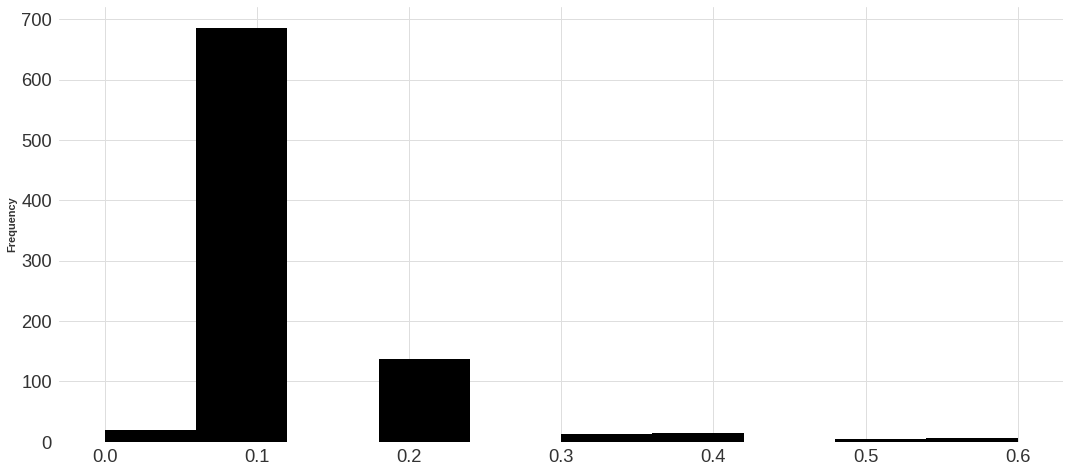

In [131]:
result_weekly['disount'].plot.hist()

In [132]:
alt.Chart(all_items_eval.reset_index()).mark_bar().encode(
    x=alt.X('model:N',scale=alt.Scale(zero=False)),
    y=alt.Y('profit_increase_%:Q',scale=alt.Scale(zero=False),axis=alt.Axis(format='%')),
    color=alt.Color('model:N')
).properties(width=250, height=250)#.interactive()

alt.Chart(...)

In [133]:
eval_df[['rmse','rmse_normalized']] = eval_df[['rmse','rmse_normalized']].astype('float16')#.groupby('model')#.sum()
all_items_eval[['rmse','rmse_normalized']] = eval_df.groupby('model').mean()[['rmse','rmse_normalized']]

In [134]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 456098.000000  185.991907  661465.581526  0.116667   
LGBM_cov             460631.682466  185.991907  667923.036279  0.128571   
LGBM_no_cov          458986.147951  185.991907  665645.339845  0.119841   
Naive weekly         459644.000000  185.991907  666524.335477  0.142857   
RegressionModelCov   464958.516852  185.991907  673688.946038  0.123016   
RegressionModelLags  463502.657138  185.991907  671653.942447  0.126984   
Theta                460359.994703  185.991907  667547.637421  0.132540   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                           164.194357            44.1    614589.500000   
LGBM_cov                       162.019527            48.6    641880.450657   
LGBM_no_cov                    163.695905            45.3    622025.793144   
Naive weekly                   159.460956            54.0    660720.800000   
RegressionModelCov             163.098767            46.5    635510.299122   
RegressionModelLags            162.249293            48.0    632608.760658   
Theta                          161.347038            50.1    645276.860702   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           782891.766457  396879.348916   
LGBM_cov                       796141.937711  400753.821767   
LGBM_no_cov                    789609.343085  399387.203907   
Naive weekly                   795436.639964  399914.601286   
RegressionModelCov             800441.837560  404213.367623   
RegressionModelLags            796906.999241  402992.365468   
Theta                          791490.754107  400528.582452   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          425889.291982    456098.0      396879.348916   
LGBM_cov                      423599.224660    456098.0      396879.348916   
LGBM_no_cov                   428773.922877    456098.0      396879.348916   
Naive weekly                  412306.854752    456098.0      396879.348916   
RegressionModelCov            431942.306357    456098.0      396879.348916   
RegressionModelLags           429706.254186    456098.0      396879.348916   
Theta                         417157.381725    456098.0      396879.348916   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             614589.5                425889.291982   
LGBM_cov                         634152.8                420067.423128   
LGBM_no_cov                      617918.3                425914.837171   
Naive weekly                     654527.9                409243.237147   
RegressionModelCov               625032.8                423828.888356   
RegressionModelLags              622295.0                423505.414027   
Theta                            639515.3                412675.119939   

                     inventory_left  final_profit_w_discount  \
model                                                          
Fact                       0.000000            425889.291982   
LGBM_cov                7727.650657            432933.497551   
LGBM_no_cov             4107.493144            442423.698223   
Naive weekly            6192.900000            422476.948606   
RegressionModelCov     10477.499122            437269.114474   
RegressionModelLags    10313.760658            435605.489857   
Theta                   5761.560702            424509.449043   

                     final_profit_base_price  profit_increase_%      rmse  \
model                                                     

In [135]:
chart = alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('rmse:Q'),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

fact_line = alt.Chart(pd.DataFrame({'y': [all_items_eval.loc['Fact','profit_increase_%']]})).mark_rule(strokeDash=[10, 10]).encode(y='y')

chart + fact_line

alt.LayerChart(...)

In [136]:
alt.Chart(all_items_eval.fillna(0).reset_index()).mark_circle().encode(
    x=alt.X('disount:Q',axis=alt.Axis(format='%')),
    y=alt.Y('profit_increase_%:Q',axis=alt.Axis(format='%')),
    color=alt.Color('model:N'),
).properties(width=450, height=450)#.interactive()

alt.Chart(...)

In [137]:
all_items_eval

value  sell_price  daily_revenue   disount  \
model                                                                     
Fact                 456098.000000  185.991907  661465.581526  0.116667   
LGBM_cov             460631.682466  185.991907  667923.036279  0.128571   
LGBM_no_cov          458986.147951  185.991907  665645.339845  0.119841   
Naive weekly         459644.000000  185.991907  666524.335477  0.142857   
RegressionModelCov   464958.516852  185.991907  673688.946038  0.123016   
RegressionModelLags  463502.657138  185.991907  671653.942447  0.126984   
Theta                460359.994703  185.991907  667547.637421  0.132540   

                     sell_price_w_disount  value_increase  value_w_disount  \
model                                                                        
Fact                           164.194357            44.1    614589.500000   
LGBM_cov                       162.019527            48.6    641880.450657   
LGBM_no_cov                    163.695905            45.3    622025.793144   
Naive weekly                   159.460956            54.0    660720.800000   
RegressionModelCov             163.098767            46.5    635510.299122   
RegressionModelLags            162.249293            48.0    632608.760658   
Theta                          161.347038            50.1    645276.860702   

                     daily_revenue_w_disount   daily_profit  \
model                                                         
Fact                           782891.766457  396879.348916   
LGBM_cov                       796141.937711  400753.821767   
LGBM_no_cov                    789609.343085  399387.203907   
Naive weekly                   795436.639964  399914.601286   
RegressionModelCov             800441.837560  404213.367623   
RegressionModelLags            796906.999241  402992.365468   
Theta                          791490.754107  400528.582452   

                     daily_profit_w_disount  value_fact  daily_profit_fact  \
model                                                                        
Fact                          425889.291982    456098.0      396879.348916   
LGBM_cov                      423599.224660    456098.0      396879.348916   
LGBM_no_cov                   428773.922877    456098.0      396879.348916   
Naive weekly                  412306.854752    456098.0      396879.348916   
RegressionModelCov            431942.306357    456098.0      396879.348916   
RegressionModelLags           429706.254186    456098.0      396879.348916   
Theta                         417157.381725    456098.0      396879.348916   

                     value_w_disount_fact  daily_profit_w_disount_fact  \
model                                                                    
Fact                             614589.5                425889.291982   
LGBM_cov                         634152.8                420067.423128   
LGBM_no_cov                      617918.3                425914.837171   
Naive weekly                     654527.9                409243.237147   
RegressionModelCov               625032.8                423828.888356   
RegressionModelLags              622295.0                423505.414027   
Theta                            639515.3                412675.119939   

                     inventory_left  final_profit_w_discount  \
model                                                          
Fact                       0.000000            425889.291982   
LGBM_cov                7727.650657            432933.497551   
LGBM_no_cov             4107.493144            442423.698223   
Naive weekly            6192.900000            422476.948606   
RegressionModelCov     10477.499122            437269.114474   
RegressionModelLags    10313.760658            435605.489857   
Theta                   5761.560702            424509.449043   

                     final_profit_base_price  profit_increase_%      rmse  \
model                                                     